In [1]:
import os
import pandas as pd
d = pd.read_csv("PAMAP2_Dataset/Protocol/subject101.dat", sep=" ", header=None)



<Axes: >

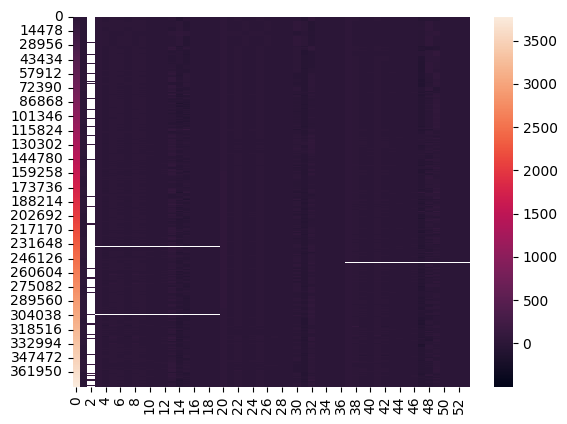

In [2]:
import seaborn as sns
sns.heatmap(d)

In [3]:
d = d.dropna(axis=0, how='any')

In [4]:
grouped = d.groupby(1)
n_activities = grouped.ngroups
processed = grouped.head(10).drop(0, axis=1)

In [5]:
processed.to_csv("processed_101.csv", sep=" ", header=None, index=False)

In [6]:
from sklearn.mixture import GaussianMixture


def cluster(df, n):
    gmm = GaussianMixture(n_components=n).fit(df)
    return gmm.predict(df)


labels = cluster(processed, n_activities)

In [7]:
labels

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

# Own implementation

In [8]:
# from dataclasses import dataclass
# import numpy as np
# import scipy.stats as stats
# from scipy.special import digamma

# @dataclass
# class ClusterHyperparams:
#     alpha: float
#     beta: float
#     m: float
#     nu: float
#     W: float

# def my_gmm(cps: list[ClusterHyperparams], data: pd.DataFrame):
#     n_components = len(cps)
#     D = len(data.columns)
#     mixture_weights = np.random.dirichlet([cps[i].alpha for i in range(n_components)]) # pi
#     mixture_means = [np.random.normal(cps[i].m, cps[i].beta) for i in range(n_components)] # maybe here should be some different initialization
#     precision_matrix = [stats.wishart(cp.W, cp.nu).rvs(size=n_components) for cp in cps] # lambda
    
    
#     # E-step
#     alphas = digamma(sum(cp.alpha for cp in cps))
#     ln_mixture_weights = [digamma(cp.alpha) - alphas for cp in cps]
#     ln_weights_mean = np.mean(ln_mixture_weights)
#     # ---------
#     precision_matrices = []
#     for cp in cps:
#         precision_matrix = np.mean([digamma(sum([cp.nu - 1 - col for col in row])) + D * np.log(2) + np.log (cp.W) for row in data.iterrows()])
#         precision_matrices.append(precision_matrix)

    
#     def correlation_coefficient(i):
#         weight, precision = ln_weights_mean[i], precision_matrices[i]
        
#         return precision * np.sqrt(weight) * np.exp(
#             -D/(2 * cps[i].beta) 
#             + cps[i].nu / 2 * ())
#     correlation_coefficients = [correlation_coefficient(i) for i in range(n_components)]

    
#     # for row in data.iterrows():
        
#     # def compute_row(row):
#     #     # for cp in cps
#     #     # sum(digamma((cp.nu + 1 - col))  for col in row)

#     # sum([compute_row(row) for row in data.iterrows()])
        

    


# n_components = 3
# my_gmm([ClusterHyperparams(1, 1, 1, 1, 1)] * n_components, processed)

In [9]:
# python based GMM
import numpy as np
from scipy.stats import multivariate_normal
from dataclasses import dataclass

@dataclass
class ClusterHyperparams:
    alpha: float
    beta: float
    m: float
    nu: float
    W: float

def gmm(n_components, data: np.ndarray, mixture_means = None, mixture_sigma = None, mixture_weights = None):
    num_records, D = data.shape
    
    
    if mixture_means is None:
        mixture_means =  np.random.random((n_components, D))
    if mixture_sigma is None:
        mixture_sigma =  np.zeros((n_components, D, D))
        for i in range(n_components):
            mixture_sigma[i] = np.eye(D)
    if mixture_weights is None:
        mixture_weights = np.random.random(n_components)
    
    responsibilities = np.zeros((num_records, n_components))


    # expectation step
    for c in range(n_components):
        responsibilities[:, c] = mixture_weights[c] * multivariate_normal.pdf(data, mixture_means[c], mixture_sigma[c])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
  
    # maximization step
    sum_responsibilities = responsibilities.sum(axis=0)
    mixture_weights = sum_responsibilities / num_records
    mixture_means = (responsibilities.T @ data) / sum_responsibilities[:, None]
    for c in range(n_components):
        j = np.expand_dims(data, axis=1) - mixture_means[c]
        s = j.transpose(0, 2, 1) @ j
        mixture_sigma[c] = (s.transpose(1, 2, 0) @ responsibilities[:, c]) / sum_responsibilities[c]
    
    return mixture_means, mixture_sigma, mixture_weights

In [10]:

from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

def plot_gaussian(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            edgecolor='k')
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def draw(ax, k, mu, sigma, n_std=2.0, facecolor='none', **kwargs):
    '''
    Function to draw the Gaussians.
    Note: Only for two-dimensionl dataset
    '''
    for i in range(k):
        plot_gaussian(mu[i], sigma[i], ax, n_std=n_std, **kwargs)

def plot(X, n_components, mu, sigma):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(mu[:, 0], mu[:, 1])
    draw(ax, n_components, mu, sigma, lw=3)
    ax.set_xlim((-12, 12))
    ax.set_ylim((-12, 12))
    
    plt.show()
    plt.clf()

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    return x

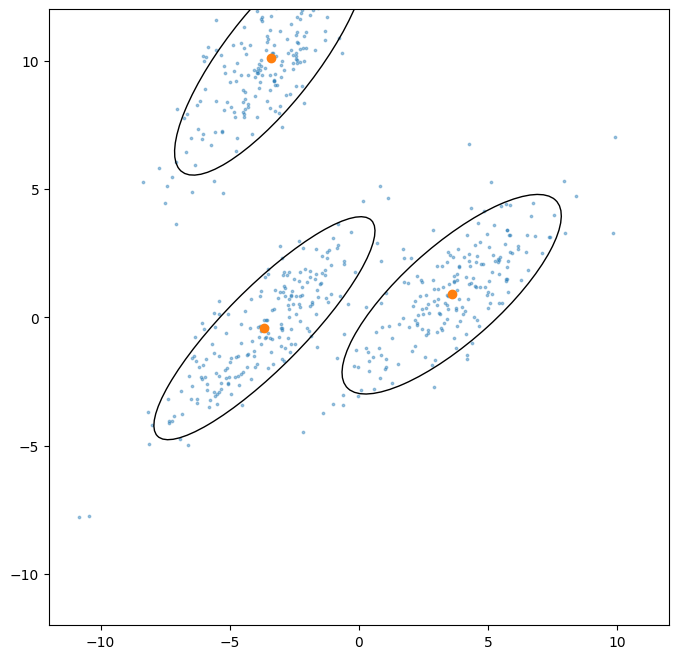

<Figure size 640x480 with 0 Axes>

In [11]:
num_iters = 100
n_components = 3
X = gen_data()
mixture_means, mixture_sigma, mixture_weights = (None,) * 3
for k in range(num_iters):
    mixture_means, mixture_sigma, mixture_weights = gmm(n_components, X, mixture_means, mixture_sigma, mixture_weights)

plot(X, n_components, mixture_means, mixture_sigma)
    

# Test

mixture_models.cu(25): error: identifier "read_csv" is undefined

mixture_models.cu(31): error: identifier "Data" is undefined

mixture_models.cu(31): error: identifier "EM" is undefined

mixture_models.cu(33): error: identifier "store_csv" is undefined

mixture_models.cu(77): error: identifier "init_array" is undefined

mixture_models.cu(93): error: identifier "init_array" is undefined

mixture_models.cu(100): error: identifier "init_array" is undefined

mixture_models.cu(114): error: identifier "init_array" is undefined

mixture_models.cu(118): error: identifier "init_array" is undefined

mixture_models.cu(123): error: identifier "pdf" is undefined

mixture_models.cu(128): error: identifier "sum" is undefined

mixture_models.cu(142): error: identifier "matrix_multiply" is undefined

mixture_models.cu(149): error: identifier "calculate_self_dot_product" is undefined

mixture_models.cu(151): error: identifier "sum" is undefined

mixture_models.cu(169): error: identifier "invertMatrix" 

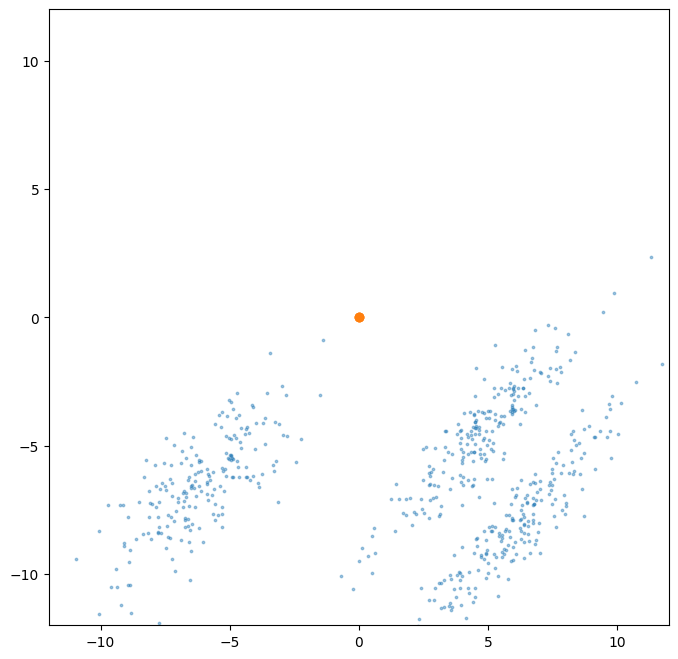

<Figure size 640x480 with 0 Axes>

In [12]:
import os 
file_name, out_name, means, sigma = "data.csv", "out", "means", "sigma"
n_components, D = 3, 2
X = gen_data(n_components, D)
size = X.shape[0]
np.savetxt(file_name, X, delimiter=",")
os.system(f"nvcc mixture_models.cu -o {out_name}")
os.system(f"./{out_name} {file_name} {n_components} {size} {D} {means} {sigma} {num_iters}")
mixture_means = np.loadtxt(means, delimiter=",")
# For mixture sigma components are stacked vertically
mixture_sigma = np.loadtxt(sigma, delimiter=",").reshape(n_components, D, D)
plot(X, n_components, mixture_means, mixture_sigma)


In [13]:
A = np.ones((256,256, 3))
np.savetxt("sigma", np.ones((9,3)))
np.savetxt("means", np.ones((3,3)))


In [14]:
for arr in (np.ones((9, 3)) * np.arange(9)[:, None]).reshape(3, 3, 3):
    print(arr)
    print("----")

[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]
----
[[3. 3. 3.]
 [4. 4. 4.]
 [5. 5. 5.]]
----
[[6. 6. 6.]
 [7. 7. 7.]
 [8. 8. 8.]]
----


# Implementation of E-step without python functions
Leaving the code, however stop working on it now since there is no need for using this algorithm. 
Instead I will find a pdf implementation in C, use it and parallelize the resulting code. 



In [15]:
from scipy.special import digamma

def calculate_responsibility(n_components, data: np.ndarray, mixture_weights: np.ndarray, mixture_means, precision_matrices, hyperparams: ClusterHyperparams):
    """
    For every data point I should calculate the probability of it to belong to each cluster
    mixture_weights - means for every item in matrix 
    """
    computed_mixture_weights = []
    D = data.shape[1]
    responsibilities = np.zeros((data.shape[0], n_components))
    
    for k in range(n_components):
        p = hyperparams[k]
        ln_mixture_weight = np.mean(digamma(p.alpha) - digamma(sum(p.alpha for p in hyperparams)))
        computed_mixture_weights.append(ln_mixture_weight)
        ln_precision_k = np.mean(digamma((p.nu + 1 - data) / 2).sum(axis=1) + D * np.log(2) + np.log(p.W), axis=0)
        
        distances_from_mean = (data - mixture_means[k]).T @ (data - mixture_means[k])
        power_term = -D / (2 * p.beta) - p.nu / 2 * p.W * distances_from_mean
        exp = np.exp(power_term)
        responsibilities[:, k] = ln_mixture_weight * np.sqrt(np.abs(ln_precision_k)) * exp
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

     

In [16]:
def specific_gmm(n_components, data: np.ndarray, mixture_means = None, mixture_sigma = None, mixture_weights = None):
    num_records, D = data.shape
    
    
    if mixture_means is None:
        mixture_means =  np.random.random((n_components, D))
    if mixture_sigma is None:
        mixture_sigma =  np.zeros((n_components, D, D))
        for i in range(n_components):
            mixture_sigma[i] = np.eye(D)
    if mixture_weights is None:
        mixture_weights = np.random.random(n_components)
    

    # expectation step
    responsibilities = calculate_responsibility(n_components, data, mixture_weights, mixture_means, mixture_sigma,  hyperparams=[ClusterHyperparams(1, 1, 1, 1, 1) for _ in range(n_components)])
  
    # maximization step
    sum_responsibilities = responsibilities.sum(axis=0)
    mixture_weights = sum_responsibilities / num_records
    mixture_means = (responsibilities.T @ data) / sum_responsibilities[:, None]
    for c in range(n_components):
        j = np.expand_dims(data, axis=1) - mixture_means[c]
        s = j.transpose(0, 2, 1) @ j
        mixture_sigma[c] = (s.transpose(1, 2, 0) @ responsibilities[:, c]) / sum_responsibilities[c]
    
    return mixture_means, mixture_sigma, mixture_weights

In [17]:
num_iters = 100
n_components = 3
X = gen_data()
mixture_means, mixture_sigma, mixture_weights = (None,) * 3
for k in range(num_iters):
    mixture_means, mixture_sigma, mixture_weights = specific_gmm(n_components, X, mixture_means, mixture_sigma, mixture_weights)

plot(X, n_components, mixture_means, mixture_sigma)
    

/tmp/ipykernel_9589/2844991925.py:20: RuntimeWarning: overflow encountered in exp
  exp = np.exp(power_term)


ValueError: could not broadcast input array from shape (2,2) into shape (600,)

In [ ]:
np.ones((10,5)).T @ np.ones((10,5))

array([[10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.]])